# Nowcasting

## Packages and Setting

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from functools import reduce
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from ExtendedDynamicFactor import ExtendedDynamicFactor, OptimizeExtendedDynamicFactor

%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# HELPER FUNCTION
def to_quarter(date):
    date = pd.to_datetime(date)
    return f'{date.year}Q{(date.month+2)//3}'

In [3]:
# HELPER FUNCTION
def root_mean_squared_error(diff):
    return np.sqrt(np.power(diff.dropna(), 2).mean())

## Loading Dataset

In [4]:
def load_gdp(vintage, growth=True, quarterly=True, release_lag=41, **kwargs):
    gdp = pd.read_csv('data/GDP_2014USD.csv')[['date', 'PH']].rename(columns={'PH': 'GDP'}).dropna()
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp = gdp.set_index('date')
    if quarterly:
        gdp = gdp.resample('Q').sum()
        gdp = 100 * (gdp / gdp.shift(4) - 1) if growth else gdp
    else:
        gdp = gdp.resample('Y').sum()
        gdp = 100 * (gdp / gdp.shift(1) - 1) if growth else gdp
    gdp = gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=release_lag), :]
    gdp.index = pd.PeriodIndex(gdp.index, freq=('Q' if quarterly else 'Y'))

    return gdp.dropna()

In [5]:
def load_tweets(vintage, keywords=['PE'], metrics=['TBweight_cl2rt', 'VADERweight_cl2rt'], **kwargs):
    tweets = pd.read_csv('data/PH_Tweets.csv')
    tweets['date'] = pd.to_datetime(tweets['date'])
    tweets = tweets.set_index('date')
    keywords = keywords if len(keywords) > 0 else list(tweets['keyword'].unique())
    metrics = metrics if len(metrics) > 0 else list(tweets.columns.drop(['keyword']))
    tweets = tweets[metrics + ['keyword']]
    tweets_keyword = [tweets[tweets['keyword'] == keyword].drop(columns=['keyword']).add_suffix(f'_{keyword}') for keyword in keywords]
    tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), tweets_keyword)
    tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
    tweets.index = pd.PeriodIndex(tweets.index, freq='M')
    
    return tweets

## Quarter to Annual GDP Growth Conversion

In [6]:
def quarter_to_annual(vintage, nowcasts):
    # LOAD GDP DATA
    quarter_gdp = load_gdp(vintage, False, True)
    annual_gdp = load_gdp(vintage, False, False)

    # GET QUARTERLY GDP
    nowcasts = nowcasts.copy()
    for m in range(4):
        quarter = 3 * (m + 1)
        prev_quarter = vintage - relativedelta(years=1) + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[prev_quarter, 'GDP'] * (1 + nowcasts[m] / 100)
        # PAD OBSERVED
        curr_quarter = vintage + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[curr_quarter, 'GDP'] if curr_quarter in quarter_gdp.index else nowcasts[m]
    
    # GET ANNUAL GDP GROWTH
    prev_year = vintage - relativedelta(years=1)
    return 100 * (np.sum(nowcasts) / annual_gdp.loc[prev_year, 'GDP'] - 1)

## Dynamic Factor Model for Tweets

In [7]:
def DFM_Tweets(vintage_now, factor_order, error_order, k_factors, factor_lag, optimize_order, **kwargs):
    # LOAD DATA
    vintage_now = pd.to_datetime(vintage_now)
    tweets = load_tweets(vintage_now, **kwargs)

    # FIT MODEL
    if optimize_order:
        model = OptimizeExtendedDynamicFactor(
            endog=tweets, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
            error_order=error_order, **kwargs
        ).optimize(**kwargs)
    else:
        model = ExtendedDynamicFactor(
            endog=tweets, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
            error_order=error_order, **kwargs
        )
    results = model.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
    
    # NOWCAST
    tweets = pd.concat([tweets, results.predict(start=vintage_now, end=vintage_now + pd.offsets.YearEnd(0))])
    return tweets

## Machine Learning

In [8]:
def runML(DFM_order, gdp_lag=1, tweet_lag=3, optimize_order=False, **kwargs):
    # PRINT SPECIFICATIONS
    print(f'Tweets: DFM{DFM_order}')
    if optimize_order:
        print('[WARNING] Input orders are used as upper limits with optimize_order')
    print(f'GDP Lags: {gdp_lag}')
    print(f'Tweet Lags: {tweet_lag}')

    # LOAD ACTUAL GDP
    annual_gdp = load_gdp('2023-01-01', True, False, 0)
    quarter_gdp = load_gdp('2023-01-01', True, True, 0)

    # SAVED RESULTS
    results = []
    if not os.path.exists(f'Results'):
        os.makedirs(f'Results')

    # FORECAST DATES 
    vintage_now = dt.datetime(2017, 1, 1)
    vintage_end = dt.datetime(2022, 12, 1)
    delta = relativedelta(months=1)

    while vintage_now <= vintage_end:
        # GET ACTUAL GDP
        annual = annual_gdp.loc[vintage_now, 'GDP']
        quarter = quarter_gdp.loc[vintage_now, 'GDP']
        
        try:
            # LOAD DATA
            df = load_gdp(vintage_now, **kwargs)
            tweets = DFM_Tweets(vintage_now, *DFM_order, optimize_order, **kwargs)
            tweets = pd.concat([tweets.shift(l).add_suffix(f'.L{l}') for l in range(tweet_lag)], axis=1).resample('Q').last()
            tweets.index.name = 'date'
            df = pd.merge(df, tweets, how='outer', on='date', sort=True)
            for l in range(1, gdp_lag + 1): 
                df[f'GDP.L{l}'] = df['GDP'].shift(l)
            df = df.iloc[max(gdp_lag, tweet_lag//3):,:]

            # FIT MODEL
            X_test = df.loc[vintage_now + relativedelta(month=3) :, df.columns.drop('GDP')]
            X_test_q = X_test.loc[vintage_now : vintage_now, :]
            X_train = df.dropna().loc[: vintage_now - relativedelta(months=3), df.columns.drop('GDP')]
            y_train = df.dropna().loc[: vintage_now - relativedelta(months=3), 'GDP']
            model = ElasticNet()
            model.fit(X_train, y_train)

            # GET FORECASTS
            nowcasts = [np.nan * 4] if X_test.isnull().values.any() else model.predict(X_test)
            nowcast_annual = np.nan if X_test.isnull().values.any() else quarter_to_annual(vintage_now, nowcasts)
            nowcast_quarter = np.nan if X_test_q.isnull().values.any() else model.predict(X_test_q)[0]

            # APPEND RESULTS
            results.append([vintage_now, to_quarter(vintage_now), nowcast_annual, annual, nowcast_quarter, quarter] + list(nowcasts))
            
            # CURRENT VINTAGE
            print(f'Vintage: {vintage_now.date()}')
        
        except Exception as ex:
            # with open(f'Results/ML_{str(vintage_now.date())}_error.txt', 'w') as f:
            #     f.write(str(ex))
            print(f'Vintage: {vintage_now.date()} \t {ex}')
            
            results.append([vintage_now, to_quarter(vintage_now), np.nan, annual, np.nan, quarter] + [np.nan * 4])

        vintage_now += delta

    # SUMMARIZE RESULTS
    results = pd.DataFrame(results, columns=['date', 'Quarter', 'Nowcast_A', 'Actual_A', 'Nowcast_Q', 'Actual_Q'] + [f'ForecastQ{q}' for q in range(1,5)])
    results['date'] = pd.to_datetime(results['date'])
    results['Period'] = np.where(results['date'].dt.year < 2020, 1, 0)
    results['Year'] = results['date'].dt.year
    results['Month_Q'] = results['date'].dt.month % 3
    results['Month_A'] = results['date'].dt.month

    # RMSE CALCULATIONS
    for freq, periods in zip(['A', 'Q'], [['Month_A', 'Month_Q', 'Year', 'Period'], ['Month_Q', 'Quarter', 'Period']]):
        results[f'Difference_{freq}'] = results[f'Nowcast_{freq}'] - results[f'Actual_{freq}']
        results[f'Overall_RMSE_{freq}'] = root_mean_squared_error(results[f'Difference_{freq}'])
        for period in periods:
            results = results.set_index(period)
            results[f'{period}_RMSE_{freq}'] = results.groupby(period).apply(lambda df: root_mean_squared_error(df[f'Difference_{freq}']))
            results = results.reset_index()
    results = results.drop(columns=['Period', 'Year', 'Quarter', 'Month_A', 'Month_Q'])
    results = results.rename(columns={'Month_A_RMSE_A': 'Month_RMSE_A', 'Month_Q_RMSE_A': 'Quarter_RMSE_A', 'Month_Q_RMSE_Q': 'Month_RMSE_Q'})
    results = results[['date'] + [col for col in results.columns if '_A' in col] + [col for col in results.columns if '_Q' in col] + [f'ForecastQ{q}' for q in range(1,5)]]
    
    # SAVE AGGREGATED RESULTS
    if kwargs.get('save_aggregate', True):
        header = 'DFM_OPT' if optimize_order else f'DFM{DFM_order}'
        results.to_csv(f'Results/ML_{header}_summary.csv', index=False)
    
    return results

Tweets: DFM(4, 2, 1, 3)
GDP Lags: 0
Tweet Lags: 3
Vintage: 2017-01-01 	 datetime.datetime(2016, 12, 1, 0, 0)
Vintage: 2017-02-01 	 datetime.datetime(2016, 12, 1, 0, 0)
Vintage: 2017-03-01
Vintage: 2017-04-01
Vintage: 2017-05-01
Vintage: 2017-06-01
Vintage: 2017-07-01
Vintage: 2017-08-01
Vintage: 2017-09-01
Vintage: 2017-10-01
Vintage: 2017-11-01
Vintage: 2017-12-01
Vintage: 2018-01-01 	 datetime.datetime(2017, 12, 1, 0, 0)
Vintage: 2018-02-01 	 datetime.datetime(2017, 12, 1, 0, 0)
Vintage: 2018-03-01
Vintage: 2018-04-01
Vintage: 2018-05-01
Vintage: 2018-06-01
Vintage: 2018-07-01
Vintage: 2018-08-01
Vintage: 2018-09-01
Vintage: 2018-10-01
Vintage: 2018-11-01
Vintage: 2018-12-01
Vintage: 2019-01-01 	 datetime.datetime(2018, 12, 1, 0, 0)
Vintage: 2019-02-01 	 datetime.datetime(2018, 12, 1, 0, 0)
Vintage: 2019-03-01
Vintage: 2019-04-01
Vintage: 2019-05-01
Vintage: 2019-06-01
Vintage: 2019-07-01
Vintage: 2019-08-01
Vintage: 2019-09-01
Vintage: 2019-10-01
Vintage: 2019-11-01 	 LU decompositi

,date,Nowcast_A,Actual_A,Difference_A,Overall_RMSE_A,Month_RMSE_A,Quarter_RMSE_A,Year_RMSE_A,Period_RMSE_A,Nowcast_Q,Actual_Q,Difference_Q,Overall_RMSE_Q,Month_RMSE_Q,Quarter_RMSE_Q,Period_RMSE_Q,ForecastQ1,ForecastQ2,ForecastQ3,ForecastQ4
0,2017-01-01,NaN,6.930988,NaN,5.372954,NaN,4.712838,0.508235,0.317339,NaN,6.374133,NaN,11.014396,7.622554,0.053785,0.560058,NaN,NaN,NaN,NaN
1,2017-02-01,NaN,6.930988,NaN,5.372954,NaN,5.897776,0.508235,0.317339,NaN,6.374133,NaN,11.014396,8.123418,0.053785,0.560058,NaN,NaN,NaN,NaN
2,2017-03-01,6.320348,6.930988,-0.610640,5.372954,7.130842,5.421687,0.508235,0.317339,6.320348,6.374133,-0.053785,11.014396,14.327707,0.053785,0.560058,6.320348,6.320348,6.320348,6.320348
3,2017-04-01,6.320348,6.930988,-0.610640,5.372954,6.638142,4.712838,0.508235,0.317339,6.320348,7.177099,-0.856751,11.014396,7.622554,0.856111,0.560058,6.320348,6.320348,6.320348,6.320348
4,2017-05-01,6.320348,6.930988,-0.610640,5.372954,6.641186,5.897776,0.508235,0.317339,6.320348,7.177099,-0.856751,11.014396,8.123418,0.856111,0.560058,6.320348,6.320348,6.320348,6.320348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2022-08-01,8.501334,7.599235,0.902099,5.372954,6.976423,5.897776,1.226335,7.591875,9.082087,7.635937,1.446150,11.014396,8.123418,1.943058,15.566637,8.610849,9.453667,9.082087,7.440750
68,2022-09-01,6.914770,7.599235,-0.684465,5.372954,2.351305,5.421687,1.226335,7.591875,5.848434,7.635937,-1.787504,11.014396,14.327707,1.943058,15.566637,8.250450,9.017287,5.848434,6.307020
69,2022-10-01,6.968812,7.599235,-0.630423,5.372954,2.724017,4.712838,1.226335,7.591875,6.246719,7.225544,-0.978825,11.014396,7.622554,1.938720,15.566637,8.250450,9.017287,6.145671,6.246719
70,2022-11-01,7.026897,7.599235,-0.572338,5.372954,2.633213,5.897776,1.226335,7.591875,6.453733,7.225544,-0.771811,11.014396,8.123418,1.938720,15.566637,8.250450,9.017287,6.145671,6.453733


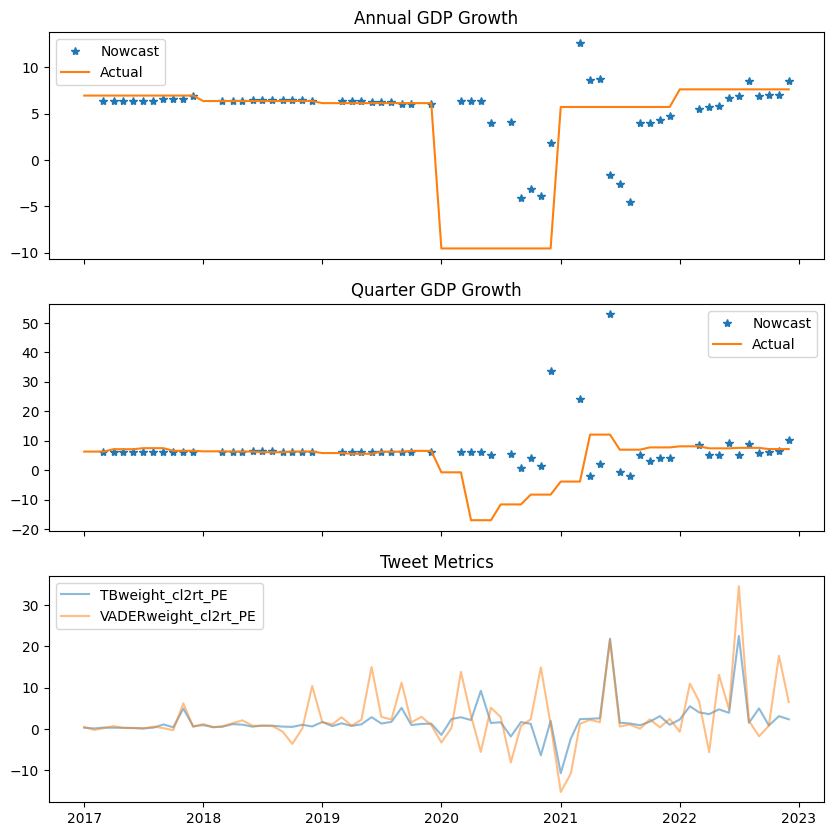

In [9]:
results = runML(DFM_order=(4,2,1,3), gdp_lag=0, tweet_lag=3)
# results = pd.read_csv('Results/ML_DFM(4, 2, 1, 3)_summary.csv', parse_dates=['date'])
tweets = load_tweets('2023-01-01').loc[dt.datetime(2017,1,1):,:]
tweets.index = tweets.index.to_timestamp()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
axs[0].plot(results['date'], results['Nowcast_A'], linewidth=0, marker='*', label='Nowcast')
axs[0].plot(results['date'], results['Actual_A'], label='Actual')
axs[0].legend()
axs[0].set_title('Annual GDP Growth')
axs[1].plot(results['date'], results['Nowcast_Q'], linewidth=0, marker='*', label='Nowcast')
axs[1].plot(results['date'], results['Actual_Q'], label='Actual')
axs[1].legend()
axs[1].set_title('Quarter GDP Growth')
for metric in tweets.columns:
    axs[2].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[2].legend()
axs[2].set_title('Tweet Metrics')
fig.show()
results